In [1]:
import pandas as pd
import numpy as np
import requests
import json
import urllib
import os.path

In [2]:
link_f    = 'ml-latest-small/ml-latest-small/links.csv'
poster_pt = 'posters/'
download_posters = 9000

headers = {'Accept':'application/json'}
payload = {'api_key':'20047cd838219fb54d1f8fc32c45cda4'} ## api appiled from movie database
response = requests.get('http://api.themoviedb.org/3/configuration',params=payload,headers=headers)
response = json.loads(response.text)

base_url = response['images']['base_url']+'w185'

In [3]:
def get_poster(imdb,base_url):
    #query themovie.org API for movie poster path.
    file_path = ''
    imdb_id = 'tt0{0}'.format(imdb)
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(imdb_id)
    response = requests.get(movie_url,params=payload,headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        print('Failed to get url for imdb: {0}'.format(imdb))

    return base_url+file_path

In [4]:
df_id = pd.read_csv(link_f,sep=',')
idx_to_mv = {}
for row in df_id.itertuples():
    idx_to_mv[row[1]-1] = row[2]

mvs = [0]*len(idx_to_mv.keys())
for i in range(len(mvs)):
    if i in idx_to_mv.keys() and len(str(idx_to_mv[i])) == 6:
        mvs[i] = idx_to_mv[i]
mvs = list(filter(lambda imdb:imdb!=0,mvs))
mvs = mvs[:download_posters]
total_mvs = len(mvs)

In [5]:
#df_id = pd.read_csv(link_f,sep=',')
#idx_to_mv = {}
#for row in df_id.itertuples():
#    idx_to_mv[row[1]-1] = row[2]

#mvs = [0]*len(idx_to_mv.keys())
##for i in range(len(mvs)):
##    mvs[i] = idx_to_mv[i]
#mvs =df_id.imdbId
#mvs = list(filter(lambda imdb:imdb!=0,mvs))
#mvs = mvs[:download_posters]
#total_mvs = len(mvs)

In [6]:

movie=np.array(mvs)
print(mvs[31])


114746


In [ ]:
URL = [0]*total_mvs
URL_IMDB = {'url':[],'imdb':[]}

i = 0
for m in mvs:
    if(os.path.exists(poster_pt+str(i)+'.jpg')):
        print('Skip downloading exists jpg: {0}.jpg'.format(poster_pt+str(i)))
        i += 1
        continue
    URL[i] = get_poster(m,base_url)
    if(URL[i] == base_url):
        print('Bad imdb id: {0}'.format(m))
        mvs.remove(m)
        continue
    print('No.{0}: Downloading jpg(imdb {1}) {2}'.format(i,m,URL[i]))
    urllib.request.urlretrieve(URL[i],poster_pt+str(i)+'.jpg')
    URL_IMDB['url'].append(URL[i])
    URL_IMDB['imdb'].append(m)
    i += 1

In [8]:
movie=np.array(mvs)
print(movie.shape)

(3077,)


In [10]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage


In [ ]:
image = [0]*total_mvs
x     = [0]*total_mvs
print(image)

In [11]:
def save_predict_res(matrix_res):
    pe = dict([(x,[]) for x in range(matrix_res.shape[0])])
    for i in range(matrix_res.shape[0]):
        pe[i].extend(matrix_res[i])
    df = pd.DataFrame(data=pe)
    df.to_csv('prediction_result.csv')

In [12]:
def save_url_res(matrix_res):
    pe = dict([(x,[]) for x in range(matrix_res.shape[0])])
    for i in range(matrix_res.shape[0]):
        pe[i].extend(matrix_res[i])
    df = pd.DataFrame(data=pe)
    df.to_csv('URL_IMDB.csv')

In [13]:
def load_result_matrix(file):
    if not os.path.exists(file):
        return None
    m_r = pd.read_csv(file,sep=',')
    f_r = np.zeros((m_r.shape[1]-1,m_r.shape[0]))
    for i in range(m_r.values.shape[1]-1):
        f_r[i] = m_r[str(i)].values.tolist()
    return f_r

## no need to use
## if you run this for second time, you need to use

In [14]:
import tensorflow as tf

In [15]:
import h5py as h5py

In [23]:
 resnet50=tf.keras.applications.resnet50.ResNet50(include_top=False,weights = 'imagenet', input_shape= (224, 224, 3),pooling='avg')
    

In [24]:
print(total_mvs)

3091


In [ ]:
res_mat=[]
with tf.device('/device:GPU:0'):
    for i in range(len(URL_IMDB['imdb'])):
        image[i] = kimage.load_img(poster_pt+str(i)+'.jpg',target_size=(224,224))
        x_ = tf.keras.preprocessing.image.img_to_array(image[i])
        x_ = np.expand_dims(x_, axis=0)
        x_ = tf.keras.applications.resnet50.preprocess_input(x_)
        F = resnet50.predict(x_)
        res_mat.append(F[0])
        print(i)

res_mat=np.array(res_mat)
save_predict_res(res_mat)

In [28]:
#res_mat = load_result_matrix('prediction_result')

In [45]:
np.save('user_imdb.npy',URL_IMDB)
np.save('predict_res.npy',res_mat)

In [36]:
result=np.load('predict_res.npy')
result=np.array(result)
print(result.shape)

(3063, 2048)


In [37]:
res_mat=np.array(res_mat)

In [38]:
print(res_mat.shape)

(3063, 2048)


In [39]:
similarity_deep = res_mat.dot(res_mat.T)
norms = np.array([np.sqrt(np.diagonal(similarity_deep))])
similarity_deep = (similarity_deep/(norms*norms.T))

In [40]:
klist=URL_IMDB['imdb']
pos=[i for i,m in enumerate(klist) if m==112364]
print(URL_IMDB['imdb'][115])
print(pos)

112364
[115]


In [161]:
rating_f='ml-latest-small/ml-latest-small/ratings.csv'
user=pd.read_csv(rating_f,sep=',')
user_ID=8
rates=user['rating'][np.where(user.userId==user_ID)[0]]
#print(rates)
movId=user['movieId'][np.where(user.userId==user_ID)[0]]
#print(movId)
movId=np.array(movId)
rates=np.array(rates)
#print(rates)
ind=np.unravel_index(np.argmax(rates),rates.shape)## find the highest rating of a user
base_mv_idx=movId[ind[0]]# translate it to movie id
print(base_mv_idx)
imdbID=df_id['imdbId'][np.where(df_id.movieId==base_mv_idx)[0]]# translate it to imdb id
imdbID=np.array(imdbID)
klist=URL_IMDB['imdb']
pos=[i for i,m in enumerate(klist) if m==imdbID]# from imdb id we can get the index of this movie in our list
base_mv_idx=pos
print(base_mv_idx)

32
[31]


In [162]:
n_display   = 5
base_mv_idx= base_mv_idx[0]
mv = [x for x in np.argsort(similarity_deep[base_mv_idx])[:-n_display-1:-1]]

In [163]:
# recommendation result

from IPython.display import Image
from IPython.display import display
from IPython.display import HTML

images = ''
for i in range(len(mv)):
    images+="<img style='width: 100px; margin: 0px; float: left; border: 1px solid black;' src={0}.jpg />".format(poster_pt+str(mv[i]))

display(HTML(images))

In [164]:
## show the highest 5 rates movies of the user

user=pd.read_csv(rating_f,sep=',')
user_ID=user_ID
rates=user['rating'][np.where(user.userId==user_ID)[0]]
movId=user['movieId'][np.where(user.userId==user_ID)[0]]
movId=np.array(movId)
rates=np.array(rates)
ind=np.argpartition(rates, -5)[-5:]
print(ind)
wtf=np.zeros(5)
for i in range(len(ind)):
    imdbID=df_id['imdbId'][np.where(df_id.movieId==movId[ind[i]])[0]]## translate to imdb id
    wtf[i]=np.array(imdbID)
klist=URL_IMDB['imdb']
for i in range(len(ind)):
    mv[i]=[x for x,m in enumerate(klist) if m==wtf[i]]
    if mv[i]!=[]:
        mv[i]=mv[i][0]
print(mv)

[64 54 44 83  0]
[[], 1335, [], 2204, 31]


In [165]:
### print the highest rated movie of a user

from IPython.display import Image
from IPython.display import display
from IPython.display import HTML

images = ''
for i in range(len(mv)):
    images+="<img style='width: 100px; margin: 0px; float: left; border: 1px solid black;' src={0}.jpg />".format(poster_pt+str(mv[i]))

display(HTML(images))

In [166]:
## using the rates of the same user to justify if our system is googd or not
import math

rating_f='ml-latest-small/ml-latest-small/ratings.csv'
user=pd.read_csv(rating_f,sep=',')
user_ID=user_ID
rates=user['rating'][np.where(user.userId==user_ID)[0]]
#print(rates)
movId=user['movieId'][np.where(user.userId==user_ID)[0]]
#print(movId)
movId=np.array(movId)
rates=np.array(rates)
#imdbID=[]
#for i in range(movId):
#    a=df_id['imdbId'][np.where(df_id.movieId==movId[i])[0]]# find imdb id of every movieid
 #   imdbID.append(a)
#position_id=[]
#imdbID=np.array(imdbID)
#klist=URL_IMDB['imdb']
#for j in range(imdbID):
#    b=[i for i,m in enumerate(klist) if m==imdbID[j]]# find movie index with respect to our result matrix
#    position_id.append(b)
#position_id=np.array(position_id)
ind=np.linspace(0,len(rates)-1,len(rates))

print(ind)
wtf=np.zeros(len(ind))
for i in range(len(ind)):
    imdbID=df_id['imdbId'][np.where(df_id.movieId==movId[int(ind[i])])[0]]## translate to imdb id
    wtf[i]=np.array(imdbID)
klist=URL_IMDB['imdb']
mv=[None]*len(ind)
for i in range(len(ind)):
    mv[i]=[x for x,m in enumerate(klist) if m==wtf[i]]
    if mv[i]!=[]:
        mv[i]=mv[i][0]
print(mv)
for i in range(len(mv)):
    if mv[i]==[]:
        rates[i]=None
# delete all [] in rates
clean_rt=list(filter(lambda imdb:not math.isnan(imdb),rates))
# delete all [] in list mv
clean_mv = list(filter(lambda imdb:imdb!=[],mv))
mv=clean_mv

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115.]
[31, 43, 45, 48, 100, [], 250, 262, 280, 317, 401, 460, 464, 466, 480, 513, 514, 533, 628, [], [], [], [], [], [], [], [], [], 767, [], [], [], 793, [], 810, 883, 913, 959, 965, [], 1021, 1048, 1059, 1117, [], 1164, [], [], [], 1243, 1257, 1261, 1273, [], 1335, 1365, [], 1450, 1455, [], [], [], 1487, 1493, [], 1525, 1590, 1749, 1867, 1875, 1906, 1910, 1916, 1929, 1984, [], 2055, 2148, 2154, 2165, 2170, 2180

In [167]:
### print the all rated movie of a user

from IPython.display import Image
from IPython.display import display
from IPython.display import HTML

images = ''
for i in range(len(mv)):
    images+="<img style='width: 100px; margin: 0px; float: left; border: 1px solid black;' src={0}.jpg />".format(poster_pt+str(mv[i]))

display(HTML(images))

In [168]:
# split the rated movie into train and test
# train for first half movies in the list mv
# test for the remainings
t_tr=int(len(mv)/2)
tr_mv=mv[:t_tr]
#print(mv[t_tr])
keylist=([x for x in np.argsort(similarity_deep[mv[t_tr]])])# get similarity matrix based on the first test movie
last_sim_rate=0
last_sim=0
sim_rate=0
for j in range(len(tr_mv)):
    
    test_rate_1_sim=[i for i,m in enumerate(keylist) if m==tr_mv[j]]# get movie position(similarity distance) based on similarity matrix
    sim=3062-test_rate_1_sim[0]
    sim_rate=clean_rt[j]*sim
    last_sim_rate=last_sim_rate+sim_rate## calculate the fen zi
    last_sim=last_sim+sim
print(last_sim_rate/last_sim)
print(clean_rt[t_tr])

3.960434998637624
4.5


In [174]:
# now test for all rest of movies
t_tr=int(len(mv)/2)
tr_mv=mv[:t_tr]## split train test samples
te_mv=mv[t_tr:]
last_sim_rate=np.zeros(len(te_mv))
last_sim=np.zeros(len(te_mv))
sim_rate=0
predict_rate=np.zeros(len(te_mv))
for k in range(len(te_mv)):
    keylist=([x for x in np.argsort(similarity_deep[te_mv[k]])])# get similarity matrix based on the first test movie
    for j in range(len(tr_mv)):# calculate for all training sets
    
        test_rate_1_sim=[i for i,m in enumerate(keylist) if m==tr_mv[j]]# get movie position(similarity distance) based on similarity matrix
        sim=test_rate_1_sim[0]/3062# the more this score, the more similar
        sim_rate=clean_rt[j]*sim
        last_sim_rate[k]=last_sim_rate[k]+sim_rate## calculate the fen zi
        last_sim[k]=last_sim[k]+sim## calculate fen mu
        predict_rate[k]=(last_sim_rate[k]/last_sim[k])
clean_rt_x=np.array(clean_rt[t_tr:])
predict_rate=np.array(predict_rate)
predict_rate=(predict_rate-3.0)*5
print(predict_rate)
print(clean_rt_x)


[3.87408596 4.11954456 4.02403996 4.07951697 4.13139385 4.28075446
 3.83081346 4.86697563 3.44987633 4.06369713 3.98532294 3.97698098
 4.51345042 3.98386751 4.33166359 3.70927814 4.0377045  4.17223575
 3.94016049 4.08772904 4.36783728 4.28753587 3.8483493  4.46063935
 4.16406425 4.43354384 3.96020511 4.46297269 4.20737227 4.37512453
 4.43878847 4.09931713 3.94746153 4.29281946 4.56190057 4.3040087
 3.91013464 4.22194047 3.99706396]
[4.5 4.  4.5 5.  3.5 4.  4.  4.5 3.5 4.5 5.  2.5 3.5 3.5 4.5 4.  3.5 3.5
 5.  3.5 4.5 4.  4.  3.  4.  3.5 4.  3.  4.  5.  3.  3.5 4.  4.  4.  2.5
 4.5 4.  3. ]


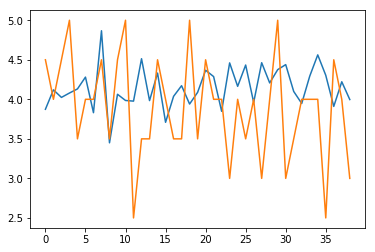

In [175]:
import matplotlib.pyplot as plt
plt.plot(predict_rate)
plt.plot(clean_rt[t_tr:])

In [131]:
len(predict_rate)

15

In [133]:
len(clean_rt[t_tr:])

15

In [ ]:
L=np.load('user_imdb.npy')
print(L)

In [184]:
np.save('url_imdburl.npy',URL_IMDB['url'])
np.save('url_imdbimdb.npy',URL_IMDB['imdb'])

In [189]:
L=np.load('url_imdbimdb.npy')
print(L)

[114709 113497 113228 ... 106912 364517 391024]
